In [1]:
from __future__ import print_function

import argparse
import os
import time, platform

import cv2
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from datasets import DATASET_NAMES, BipedDataset, TestDataset, dataset_info
from losses import *
from model import DexiNed

In [2]:
from utils import (image_normalization, save_image_batch_to_disk,
                   visualize_result)

IS_LINUX = True if platform.system()=="Linux" else False

In [3]:
IS_LINUX

True

In [4]:
device = torch.device('cpu' if torch.cuda.device_count() == 0 else 'cuda')

# Instantiate model and move it to the computing device
model = DexiNed().to(device)
# model = nn.DataParallel(model)

In [5]:
device

device(type='cuda')

In [6]:
checkpoint_path = "/media/mustafa/Elements/Workspace/Virtual_Environments/EdgeDetection/DexiNed/14_model.pth"
t1 = torch.load(checkpoint_path, map_location=device)

In [7]:
#t2 = torch.load("/home/mustafa/Downloads/bdcn/final-model/bdcn_pretrained_on_bsds500.pth", map_location=device)

In [8]:
#checkpoint_path = "/media/mustafa/Elements/Workspace/Virtual_Environments/EdgeDetection/DexiNed/14_model.pth"

#model.load_state_dict(torch.load(checkpoint_path, map_location=device))

model.load_state_dict(t1)

#t1 = torch.load(checkpoint_path, map_location=device)

<All keys matched successfully>

In [9]:
# Put model in evaluation mode
model.eval();
#model.eval()

In [10]:
import PIL

In [11]:
import albumentations as A

In [12]:
A.__version__

'0.5.2'

In [13]:
transformations = [ 
    A.Blur(p=1.0, blur_limit=100), # Range for blur_limit
    #A.ChannelDropout(p=1.0, channel_drop_range=(1,2)), # Max 2 drop, channel_drop_range=(1,1) or channel_drop_range=(1,2) or channel_drop_range=(2,2)
    #A.ChannelShuffle(p=1.0), # Max 2 drop, channel_drop_range=(1,1) or channel_drop_range=(1,2) or channel_drop_range=(2,2)
    A.CLAHE(p=1.0, clip_limit=50.0, tile_grid_size=(4,32)), # Range for clip_limit, tile_grid_size, range for both
    A.CoarseDropout(p=1.0, max_holes=20, max_height=20, max_width=20, min_holes=20, min_height=20, min_width=20), # Min to Max for all three
    A.ColorJitter(p=1.0, brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1
    A.Cutout(p=1.0, num_holes=3, max_h_size=128, max_w_size=32), # similar to CoarseDropout
    A.Downscale(p=1.0, scale_min=0.01, scale_max=0.22, interpolation=1), # from min to max
    A.DualIAATransform(p=1.0), # No param
    A.ElasticTransform(p=1.0, alpha=-10, sigma=1, alpha_affine=100, interpolation=1, border_mode=4),
    A.Equalize(p=1.0, by_channels=True), # by_channels = True or False
    #A.FancyPCA(p=1.0, alpha=120.1), # range for alpha
    #A.FDA(p=1.0, reference_images=imgsPath1, beta_limit=0.05), # images for style transfer, beta_limit range
    A.Flip(p=1.0), # simple flip
    A.GaussianBlur(p=1.0, blur_limit=(77,77), sigma_limit=(1.5,1.5) ), # limit blur, odd only, sigma_limit=
    A.GaussNoise(p=1.0, var_limit=(1000.0,2000.0), mean=64), # var_limit from to and mean from min pixel value to max pixel value
    A.GlassBlur(p=1.0, sigma=0.8, max_delta=32, iterations=3, mode='exact'), # sigma float range, max_delta switch between pixels, iterations=3, mode=
    A.GridDistortion(p=1.0, num_steps=5, distort_limit=(0.5, 0.54), interpolation=2, border_mode=3),
    A.GridDropout(p=1.0, ratio=0.3, unit_size_min=48, unit_size_max=48, holes_number_x=8, holes_number_y=8, shift_x=64, shift_y=64, random_offset=True),
    #A.HistogramMatching(p=1.0, reference_images=imgsPath1, blend_ratio=(0.1,1.0)), # Reference image list, similar to FDA
    A.HorizontalFlip(p=1.0),
    #A.HueSaturationValue(p=1.0, hue_shift_limit=(27, 27) , sat_shift_limit=(61,71), val_shift_limit=(15,25) ),
    A.IAAAdditiveGaussianNoise(p=1.0, loc=-130.0, scale=(111.55, 122.5), per_channel=True),
    A.IAAAffine(p=1.0, scale=(1.2,1.5), translate_percent=(5.0, 7.5), rotate=(4.0, 8.0), shear=(0.1,0.15), order=0),
    A.IAACropAndPad(p=1.0, percent=(0.15,0.95) ),
    A.IAAEmboss(p=1.0, alpha=(0.95,0.95), strength=(0.9,0.9)),
    A.IAAFliplr(p=1.0),
    A.IAAFlipud(p=1.0),
    A.IAAPerspective(p=1.0, scale=(0.1,0.1)),
    A.IAAPiecewiseAffine(p=1.0, scale=(0.1,0.2), nb_rows=2, nb_cols=3, order=0),
    A.IAASharpen(p=1.0, alpha=(0.9,1.0), lightness=(2.0, 2.2)),
    A.IAASuperpixels(p=1.0, p_replace=(0.3,0.3), n_segments=(70, 70) ),
    A.ImageCompression(p=1.0, quality_lower=10, quality_upper=10, compression_type=0 ),
    A.InvertImg(p=1.0),
    #A.ISONoise(p=1.0, color_shift=(0.2, 0.8), intensity=(0.2, 0.5)),    
    A.JpegCompression(p=1.0, quality_lower=10, quality_upper=10),
    A.MedianBlur(p=1.0, blur_limit=(19,19) ),
    A.MotionBlur(p=1.0, blur_limit=(19, 19) ),
    A.MultiplicativeNoise(p=1.0, multiplier=(1.9,1.9) ),
    A.OpticalDistortion(p=1.0, distort_limit=(1.1, 1.1), shift_limit=(7.75, 7.75), interpolation=0, border_mode=0),
    A.Posterize(p=1.0, num_bits=(3, 3) ),
    A.RandomBrightness(p=1.0, limit=(0.5, 0.5) ),
    A.RandomBrightnessContrast(p=1.0, brightness_limit=(0.5, 0.5), contrast_limit=(0.1, 0.1) ),
    A.RandomContrast(p=1.0, limit=(0.5, 0.5)),
    #A.RandomFog(p=1.0,   fog_coef_lower=0.3, fog_coef_upper=1, alpha_coef=0.08 ),
    A.RandomGamma(p=1.0,   gamma_limit=(60,90) ),
    A.RandomGridShuffle(p=1.0, grid=(4,4)),
    #A.RandomRain(p=1.0, slant_lower=-20, slant_upper=20, drop_length=30, drop_width=1, drop_color=(200, 200, 200), blur_value=7, brightness_coefficient=0.7, rain_type=None),
    #A.RandomShadow(p=1.0, shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=3, num_shadows_upper=3, shadow_dimension=5),
    #A.RandomSnow(p=1.0, snow_point_lower=0.03, snow_point_upper=0.04, brightness_coeff=1.5),
    #A.RandomSunFlare(p=1.0, flare_roi=(0, 0, 1, 0.5), angle_lower=0, angle_upper=1, num_flare_circles_lower=6, num_flare_circles_upper=10, src_radius=200),
    A.ShiftScaleRotate(p=1.0, shift_limit=(0.1, 0.2), scale_limit=(0.4, 0.4), rotate_limit=(40,40), interpolation=1, border_mode=4, shift_limit_x=(40,40), shift_limit_y=(40,40)),
    A.Solarize(p=1.0, threshold=92),
    #A.ToGray(p=1.0),
    #A.ToSepia(p=1.0)
]

In [14]:
for i in [40,37,36,27,22,21,10,8,6,4,3,2]:
    if(i != 6):
        print (str(transformations[i]), i)

Solarize(always_apply=False, p=1.0, threshold=(92, 92)) 40
RandomGamma(always_apply=False, p=1.0, gamma_limit=(60, 90), eps=None) 37
RandomContrast(always_apply=False, p=1.0, limit=(0.5, 0.5)) 36
InvertImg(always_apply=False, p=1.0) 27
IAAPerspective(always_apply=False, p=1.0, scale=(0.1, 0.1), keep_size=True) 22
IAAFlipud(always_apply=False, p=1.0) 21
GaussianBlur(always_apply=False, p=1.0, blur_limit=(77, 77), sigma_limit=(1.5, 1.5)) 10
Equalize(always_apply=False, p=1.0, mode='cv', by_channels=True) 8
Cutout(always_apply=False, p=1.0, num_holes=3, max_h_size=128, max_w_size=32) 4
ColorJitter(always_apply=False, p=1.0, brightness=[0.9, 1.1], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[-0.1, 0.1]) 3
CoarseDropout(always_apply=False, p=1.0, max_holes=20, max_height=20, max_width=20, min_holes=20, min_height=20, min_width=20, fill_value=0, mask_fill_value=None) 2


In [15]:
import imageio

In [16]:
image_0 = cv2.resize(imageio.imread("./Sep/PastedGraphic-1.png"), dsize=(1024,1024));
image_1 = cv2.resize(imageio.imread("./Sep/PastedGraphic-3.png"), dsize=(1024,1024));
image_2 = cv2.resize(imageio.imread("./Sep/PastedGraphic-4.png"), dsize=(1024,1024));
image_3 = cv2.resize(imageio.imread("./Sep/PastedGraphic-5.png"), dsize=(1024,1024));

In [17]:
image_0.shape

(1024, 1024, 4)

In [18]:
from matplotlib import pylab as plt
from numpy import random

def pltsubplot(listofimages, sizex, sizey):
    xrows = len(listofimages);
    yrows = len(listofimages[0]);
    
    print (xrows, yrows)

    fig, ax = plt.subplots(xrows,yrows,figsize = (sizex,sizey))

    fig.suptitle(str(xrows)+' x '+str(yrows) +" Subplots");

    for j in range(0, xrows):
        for k in range(0, yrows):
            ax[j,k].set_title("Title "+str(j)+" ,"+str(k))
            ax[j,k].imshow(listofimages[j][k], cmap="gray")
            ax[j,k].grid(b=True, which='major', color='gray', linestyle='-');

    plt.tight_layout();
    plt.show();

In [19]:
x = torch.tensor(np.moveaxis(np.expand_dims(image_2[:,:,:3],0), -1, 1), dtype=torch.float)
i1, w, h, c = x.size()
print (i1, w, h, c)

1 3 1024 1024


In [20]:
image = x.to(device)
preds = model(image)

In [21]:
img0 = preds[0].cpu().detach().numpy()[0,0,:,:];
img1 = preds[1].cpu().detach().numpy()[0,0,:,:];
img2 = preds[2].cpu().detach().numpy()[0,0,:,:];
img3 = preds[3].cpu().detach().numpy()[0,0,:,:];
img4 = preds[4].cpu().detach().numpy()[0,0,:,:];
img5 = preds[5].cpu().detach().numpy()[0,0,:,:];
img6 = preds[6].cpu().detach().numpy()[0,0,:,:];
imgList = [img0,img1,img2,img3,img4,img5,img6];

2 4


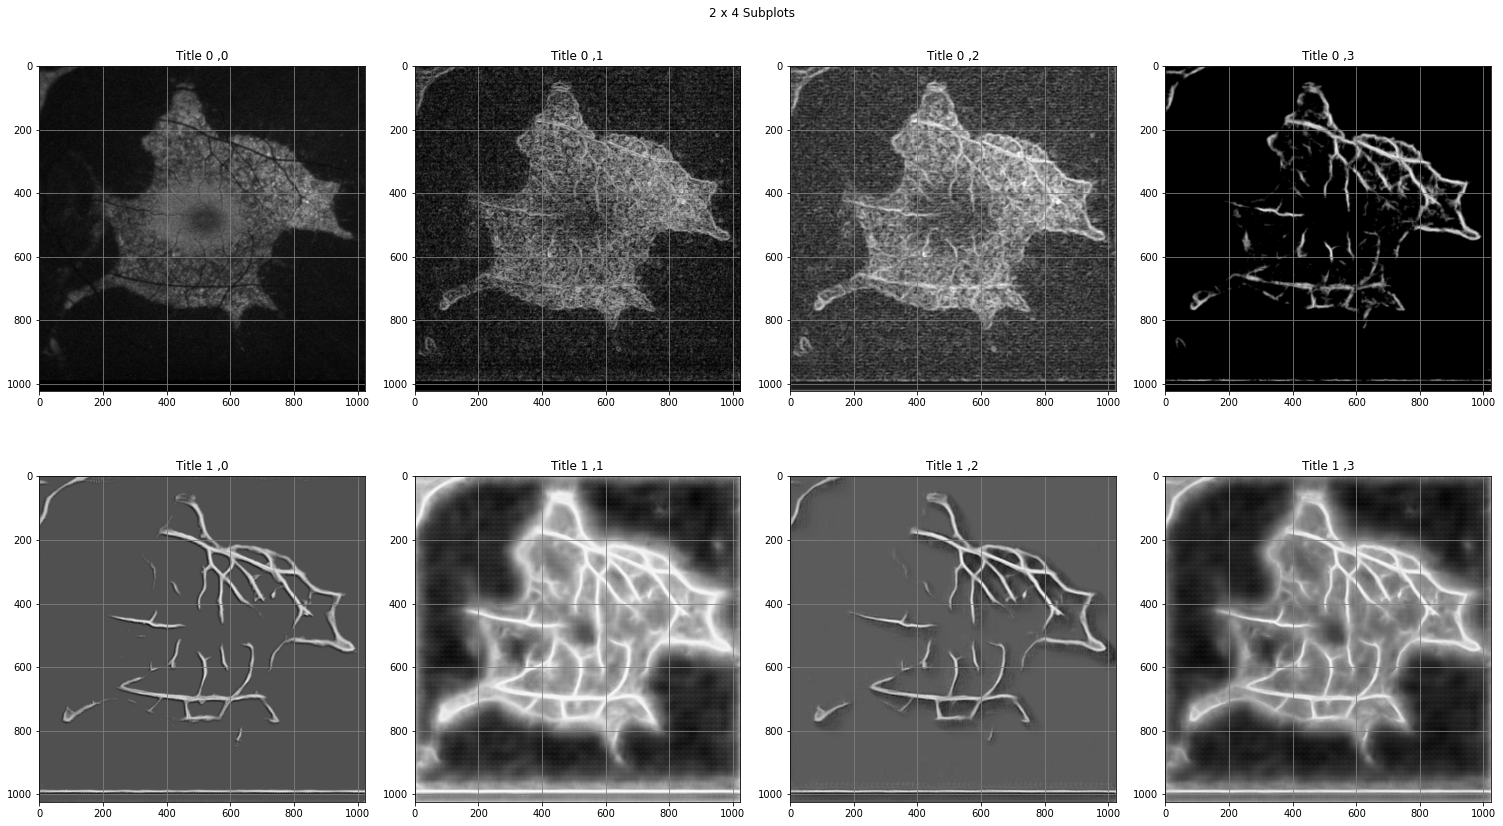

In [22]:
pltsubplot([[image_2, img0, img1, img2],[img3, img4, img5, img6]], 21, 12)

In [23]:
from skimage.data import camera
from skimage.filters import frangi, hessian
from skimage.filters import meijering, sato, frangi, hessian

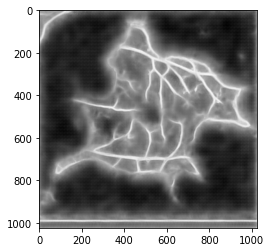

In [24]:
plt.imshow(img6,cmap="gray")

In [25]:
np.max(img6), np.min(img6)

(3.2629805, -23.567585)

In [26]:
from matplotlib import pylab as plt
from scipy import ndimage

thresh = img6>-3.000000;
thresh_After = np.copy(thresh);

label_im, nb_labels = ndimage.label(thresh)
ids, values = np.unique(label_im, return_counts=True)
sortedRanges = sorted(zip(values, ids), reverse=True)
pixelThreshold = 64;

for i in range(0, len(sortedRanges)):
    if(sortedRanges[i][0] < pixelThreshold):
        thresh_After[label_im==sortedRanges[i][1]] = 0;
    #else:
    #    thresh_After[label_im==sortedRanges[i][1]] = 1;

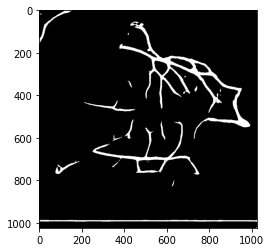

In [27]:
plt.imshow(thresh, cmap="gray")

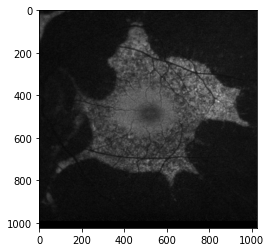

In [28]:
plt.imshow(image_2, cmap="gray")

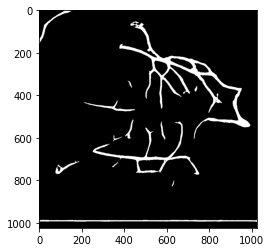

In [29]:
plt.imshow(thresh_After, cmap="gray")

In [81]:
def uncertaintyEstimation(model, image, no_iter=50, output_id=0):
    list_of_preds = [];
    model.train();
    for i in range(0, no_iter):
        preds = model(image)
        output = preds[output_id].cpu().detach().numpy()[0,0,:,:];
        list_of_preds.append(output);
    uncertainty = np.array(list_of_preds).std(axis=0)
    return uncertainty

In [82]:
uncertainty = uncertaintyEstimation(model, image, 250, 4)

In [83]:
np.min(uncertainty), np.max(uncertainty)

(0.0, 0.00012207031)

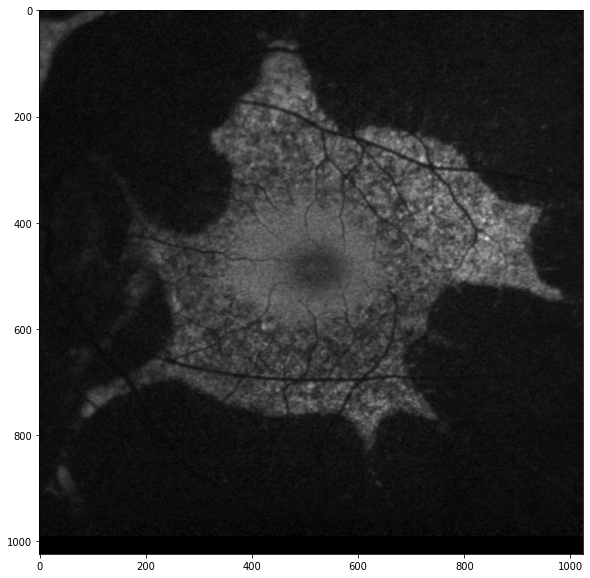

In [84]:
plt.figure(figsize=(10,10))
plt.imshow(image_2,cmap="gray")

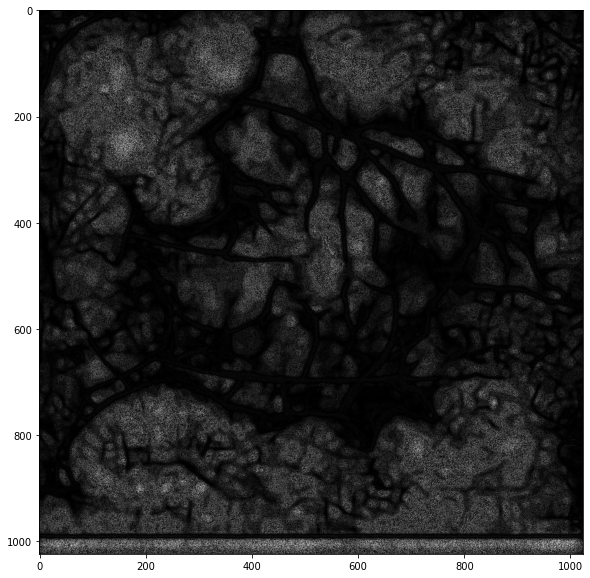

In [85]:
plt.figure(figsize=(10,10))
plt.imshow(uncertainty,cmap="gray")

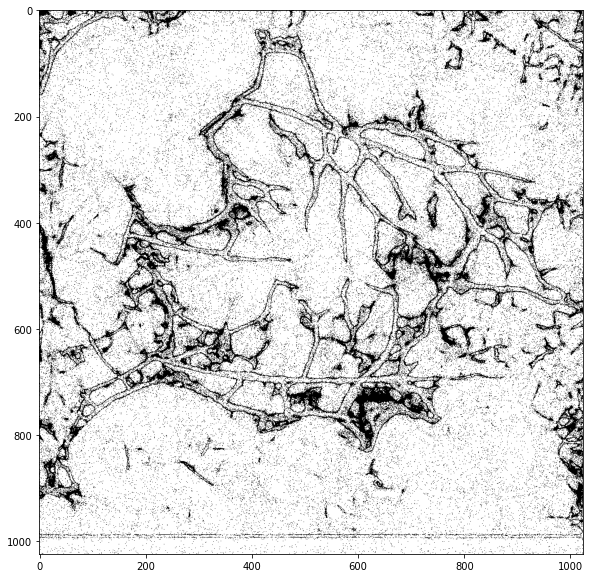

In [92]:
plt.figure(figsize=(10,10))
plt.imshow(uncertainty>0.00000125,cmap="gray")